# Portfolio Optimization

### Monte Carlo Approach (Brute Force)

##### Import the required modules

In [4]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

##### Download price data for selected stocks

In [5]:
tickers = ['AAPL', 'MSFT', 'NFLX', 'AMZN', 'GOOG', 'LUV', 'BRK-B']
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2018, 12, 31)
df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

##### Define function to calculate performance

In [6]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

##### Define function to generate randomly weighted portfolios

In [7]:
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

##### Run the Monte Carlo Simulation

In [8]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = .02
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

##### Visualize It

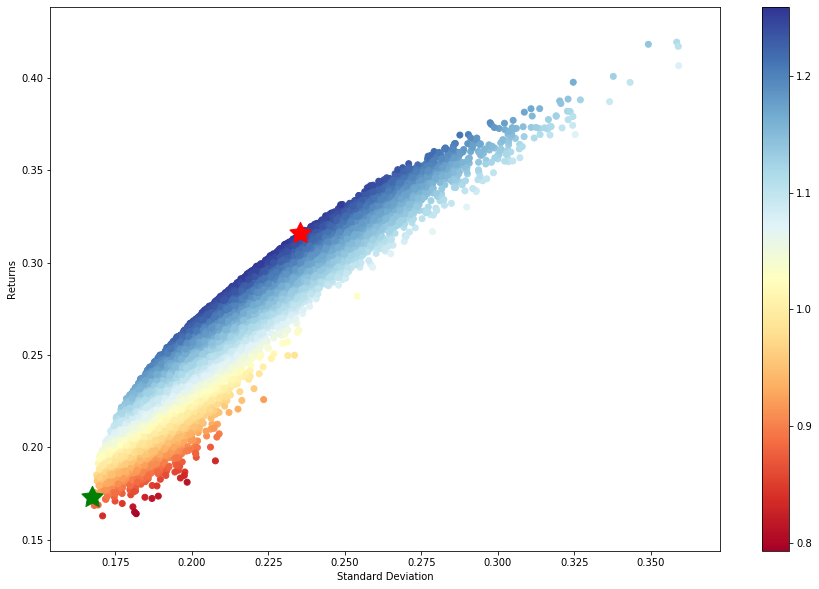

In [9]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()

##### Display Max Sharpe and Min Volatility Portfolio Weights

In [10]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,AAPL,MSFT,NFLX,AMZN,GOOG,LUV,BRK-B
81769,0.316223,0.235307,1.258877,0.23914,0.060422,0.244957,0.240759,0.000087,0.168344,0.046291


In [11]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,AAPL,MSFT,NFLX,AMZN,GOOG,LUV,BRK-B
41309,0.173266,0.167286,0.916194,0.142527,0.166836,0.005038,0.004266,0.156029,0.086046,0.439258


## Scipy Optimize Function Approach